In [2]:
%load_ext autoreload

In [1]:
%autoreload 2

from copy import deepcopy
import logging
import math
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib import colors
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy
from scipy.spatial.distance import pdist, squareform

from sklearn.metrics import r2_score
from sklearn.manifold import Isomap
import sys

sys.path.append('../../')
from data_utils import *

sys.path.append('../../../DeLASE')
from delase import *
from utils import numpy_torch_conversion
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *

sys.path.append('/om2/user/eisenaj/code/repos/jPCA')
from jPCA import jPCA

plt.style.use('../../sci_style.py')

UsageError: Line magic function `%autoreload` not found.


# Load Data

In [3]:
# session = 'MrJones-Anesthesia-20160109-01'
session = 'Mary-Anesthesia-20160912-02'
results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

In [5]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['trialInfo'], session_vars['unitInfo']

In [6]:
eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

In [7]:
section_times = dict( 
        wake=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        anesthesia=(eyes_close, session_info['drugEnd'][1]),
        recovery=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())

In [8]:
tone_on = trial_info['cpt_toneOn'][~np.isnan(trial_info['cpt_toneOn'])]
tone_off = trial_info['cpt_toneOff'][~np.isnan(trial_info['cpt_toneOff'])]

In [9]:
class PCA:
    def __init__(self, n_components=None, use_torch=False, device='cpu', dtype='torch.DoubleTensor'):
        self.n_components = n_components
        self.use_torch = use_torch
        self.device = device
        self.dtype = dtype
        
    def compute_multidim_mean(self, data):
        return data.mean(axis=tuple(np.arange(0, len(data.shape)-1)))
    
    def fit(self, data):
        data = numpy_torch_conversion(data, self.use_torch, self.device, self.dtype)   
        data_centered = data - self.compute_multidim_mean(data)
        if self.use_torch:
            U, S, Vh = torch.linalg.svd(data_centered, full_matrices=False)
            self.U = U
            self.S = S
            self.V = Vh.T

        else:
            U, S, Vh = np.linalg.svd(data_centered, full_matrices=False)
            self.U = U
            self.S = S
            self.V = Vh.T
        
        self.explained_variance_ = ((S**2)/(data.shape[0] - 1))[:self.n_components]
    
    def transform(self, data):
        data = numpy_torch_conversion(data, self.use_torch, self.device, self.dtype)
        data_centered = data - self.compute_multidim_mean(data)
        return (data_centered) @ self.V[:, :self.n_components]

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)
    
def get_bins(spike_mat, bin_size):
    """
    Helper function for get_up_down_raw() function. 

    Calculate number of bins based on bin_size, remove extra
    data at end, and return spikes/bin count array.
    """
    trial_length = spike_mat.shape[1]
    n_bins = np.floor(trial_length / bin_size)

    cut_ind = int(n_bins*bin_size)

    clipped_spike_mat = spike_mat[:,:cut_ind]
    
    return sum_bins(clipped_spike_mat, n_bins)
    
def sum_bins(spike_mat, n_bins):
    """
    Helper function for get_bins() function. 

    Break apart spike_mat (0/1 spike array) into n_bins and
    return (n_bin,) length array containing spike counts per bin.
    """
    split = np.hsplit(spike_mat, n_bins)
    join = np.stack(split)
    
    return join.sum(axis=(1,2))

def get_up_down_raw(area_spike_dict, bin_size=200, Fs=1000, thresh=0.1, 
                trange=None, smooth=True):
    """
    For each spike array in area_spike_dict, get 0/1 Up/Down array at bin_size 
    resolution.
    Optional smooth: fill in 101 case with 111
    Returns dictionary with Up/Down raw array per region.
    """
    
    areas = list(area_spike_dict.keys())

    data_length = area_spike_dict[areas[0]].shape[1]
    # n_bins = int(np.floor(data_length / bin_size))
    
    if trange is None:
        trange = np.arange(data_length)
    
    binned_up_down_dict = {}
    
    for a, spikes in area_spike_dict.items():
        if a == '7b':
            thresh = 0.2
        else:
            thresh = thresh

        binned = get_bins(spikes, bin_size)
        binned_up_down_dict[a] = (((binned / area_spike_dict[a].shape[0])\
                        * (200/bin_size)) > thresh).astype(float)

    if smooth:
        for a, binned in binned_up_down_dict.items():
            for n in range(binned.size):
                if n == 0 or n == binned.size-1:
                    pass
                else:
                    if binned[n-1] == 1 and binned[n+1] == 1:
                        binned[n] = 1

    up_down_dict = {k: np.repeat(v, bin_size) for k,v\
                    in binned_up_down_dict.items()}
    
    return up_down_dict

# NOTE - some shoddy conditionals for handling boundary issues
# WATCH FOR ISSUES
def get_up_edges(up_down_array):
    """
    Get indices for starts/ends of sequence of ones in up_down_array.
    Check / fix common errors due to boundary issues.
    """
    starts = np.where(np.diff(up_down_array) == 1)[0] + 1
    ends = np.where(np.diff(up_down_array) == -1)[0] + 1
    
    if ends[0] <= starts[0]:
        ends = ends[1:]
        starts = starts[:-1]
        
    if ends.size != starts.size:
        min_size = min(ends.size, starts.size)
        starts = starts[:min_size]
        ends = ends[:min_size]
    
    return starts, ends



def trim_up_down_array(expanded_up, area_spike_seg):
    """
    Remove trailing Up/Down labels based on 0-spike counts at 
    beginning/end of Up segement in Up/Down array.
    """
    trimmed_up = np.zeros(expanded_up.size)
    up_starts, up_ends = get_up_edges(expanded_up)
    # need to handle case where these aren't equal?
    for i in range(up_starts.size):
        s = up_starts[i]
        e = up_ends[i]
        up_seg = area_spike_seg[:,s:e]
        
        nonzeros = np.nonzero(up_seg.sum(0))[0]
        new_s = s + nonzeros[0]
        new_e = s + nonzeros[-1]
        
        trimmed_up[new_s:new_e] = 1
        
    return trimmed_up

def trim_up_down(expand_dict, area_spikes_dict):
    """
    Apply trim_up_down_array to each region in dictionary.
    """
    trimmed_dict = {}
    for a in expand_dict.keys():
        expand_up = expand_dict[a]
        spikes_seg = area_spikes_dict[a]
        
        trimmed_dict[a] = trim_up_down_array(expand_up, spikes_seg)
        
    return trimmed_dict

def get_up_down(area_spike_dict, bin_size=200):
    """
    Apply full Up/Down processing to each region in area_spike_dict.
    Returns new dictionary w/ full/processed Up/Down array per region.
    """
    raw_up_down_dict = get_up_down_raw(area_spike_dict, bin_size=bin_size)
    up_down_dict = trim_up_down(raw_up_down_dict, area_spike_dict)

    return up_down_dict

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])



In [10]:
area_spike_dict = {}
for area in np.hstack([session_info['areas']]):
    print(area)
    if area == 'all':
        unit_inds = np.arange(len(unit_info['area']))
    else:
        unit_inds = np.where(unit_info['area'] == area)[0]
    area_spike_dict[area] = np.zeros((len(unit_inds), T))
    for i, ind in enumerate(unit_inds):
        unit_spike_times = spike_times[ind]
        for t in unit_spike_times:
            area_spike_dict[area][i, int(t/dt)] = 1
up_down_dict = get_up_down(area_spike_dict, bin_size=200)

vlPFC
FEF
CPB
7b


In [33]:
# leadup = 2000
# post = 2000
# p = 1

leadup = 10000
post = 10000
p = 1

In [34]:
areas = ['vlPFC', 'FEF', '7b', 'CPB']

In [35]:
num_wake_samples = np.sum(tone_on <= session_info['drugStart'][0])
num_anesthesia_samples = np.sum(np.logical_and(tone_on > eyes_close, tone_on < session_info['drugEnd'][1]))
random_times = np.sort(np.random.uniform(0, session_info['drugStart'][0], size=(num_wake_samples,)))
random_times = np.hstack([random_times, np.sort(np.random.uniform(eyes_close, session_info['drugStart'][1], size=(num_anesthesia_samples,)))])

In [36]:
lfp_traj_wake = {}
lfp_traj_anesthesia = {}

times_wake = {}
times_anesthesia = {}

# iterator = tqdm(total=len(areas)*(len(tone_on) + len(random_times)))
iterator = tqdm(total=len(random_times) + len(tone_on))

# for i, area in enumerate(areas):
for i, area in enumerate(['vlPFC']):
    
    lfp_traj_wake[area] = {}
    lfp_traj_anesthesia[area] = {}
    
    times_wake[area] = {}
    times_anesthesia[area] = {}

    if area == 'all':
        unit_indices = np.arange(len(electrode_info['area']))
    else:
        unit_indices = np.where(electrode_info['area'] == area)[0]
    
    for time_locs, time_loc_array in [('tone', tone_on), ('random', random_times)]:
#     for time_locs, time_loc_array in [('random', random_times)]:
    
        lfp_tone_wake = []
        lfp_tone_anesthesia = []
        times_wake[area][time_locs] = []
        times_anesthesia[area][time_locs] = []
        num_wake = 0
        num_anesthesia = 0
        for t in time_loc_array:
            if t < session_info['drugStart'][0] and t > ((leadup + p - 1)*dt):
                t = int(t/dt)
                lfp_tone_wake.append(embed_signal(lfp[t - leadup -p + 1:t + post, unit_indices], p, use_torch=False))
                num_wake += 1
                times_wake[area][time_locs].append(t)
            elif t > eyes_close and t < session_info['drugEnd'][1]:
                t = int(t/dt)
                lfp_tone_anesthesia.append(embed_signal(lfp[t - leadup - p + 1:t + post, unit_indices], p, use_torch=False))
                num_anesthesia += 1
                times_anesthesia[area][time_locs].append(t)
            
            iterator.update()
        lfp_tone_wake = np.array(lfp_tone_wake)
        lfp_tone_anesthesia = np.array(lfp_tone_anesthesia)
        
        lfp_traj_wake[area][time_locs] = lfp_tone_wake
        lfp_traj_anesthesia[area][time_locs] = lfp_tone_anesthesia
        times_wake[area]
iterator.close()

  0%|          | 0/1350 [00:00<?, ?it/s]

In [38]:
area = 'vlPFC'
# AREA = CPB !!!!!!!!!!!
time_loc_type = 'random'
# time_loc_type = 'tone'

In [39]:
# n_pca_components = 10
n_pca_components = None

In [40]:
# num_pca_trajs = lfp_traj_anesthesia[area][time_loc_type].shape[0]
if n_pca_components is not None:
    num_pca_trajs = 100
    pca_traj_inds = np.random.choice(np.arange(lfp_traj_anesthesia[area][time_loc_type].shape[0]), size=(num_pca_trajs,), replace=False)
    pca = PCA(n_components=n_pca_components, use_torch=True, device='cpu')
    lfp_traj_anesthesia_pca = pca.fit_transform(lfp_traj_anesthesia[area][time_loc_type][pca_traj_inds].reshape(num_pca_trajs*(leadup + post), -1))
    
    lfp_traj_anesthesia_pca = lfp_traj_anesthesia_pca.reshape(num_pca_trajs, leadup + post, -1)
    cum_exp = torch.cumsum(pca.S.cpu()**2, 0)/(pca.S.cpu()**2).sum()
    plt.plot(cum_exp)
    plt.title(f'Anesthesia First {pca.n_components} PCAs Explain {float(cum_exp[pca.n_components - 1]):.4f}% of the Variance')
    plt.show()
    
else:
    lfp_traj_anesthesia_pca = lfp_traj_anesthesia[area][time_loc_type]

In [41]:
if n_pca_components is not None:
    pca_traj_inds = np.random.choice(np.arange(lfp_traj_wake[area][time_loc_type].shape[0]), size=(num_pca_trajs,), replace=False)
    pca = PCA(n_components=n_pca_components, use_torch=True, device='cpu')
    lfp_traj_wake_pca = pca.fit_transform(lfp_traj_wake[area][time_loc_type][pca_traj_inds].reshape(num_pca_trajs*(leadup + post), -1))

    lfp_traj_wake_pca = lfp_traj_wake_pca.reshape(num_pca_trajs, leadup + post, -1)
    cum_exp = torch.cumsum(pca.S.cpu()**2, 0)/(pca.S.cpu()**2).sum()
    plt.plot(cum_exp)
    plt.title(f'Wake First {pca.n_components} PCAs Explain {float(cum_exp[pca.n_components - 1]):.4f}% of the Variance')
    plt.show()
else:
    lfp_traj_wake_pca = lfp_traj_wake[area][time_loc_type]

In [42]:
num_trajs = 1
n_neighbors = 5

In [43]:
subsample = 50
subsample_inds = np.arange(0, leadup + post, subsample)

In [44]:
traj_inds_anesthesia = np.random.choice(np.arange(200, 260), size=(num_trajs,), replace=False)
traj_inds_wake = np.random.choice(np.arange(lfp_traj_wake_pca.shape[0]), size=(num_trajs,), replace=False)
lfp_anesthesia_in = lfp_traj_anesthesia_pca[traj_inds_anesthesia, :][:, subsample_inds].reshape(num_trajs*len(subsample_inds), -1)
lfp_wake_in = lfp_traj_wake_pca[traj_inds_wake, :][:, subsample_inds].reshape(num_trajs*len(subsample_inds), -1)

In [45]:
shared_basis = True

In [46]:
%%time

if shared_basis:
    isomap_a = Isomap(n_neighbors=n_neighbors, n_components=6)
    isomap_a.fit(np.vstack([lfp_anesthesia_in, lfp_wake_in]))
    isomap_w = isomap_a
else:
    isomap_a = Isomap(n_neighbors=n_neighbors, n_components=6)
    start = time.time()
    isomap_a.fit(lfp_anesthesia_in)
    end = time.time()
    print(f'Anesthesia complete! Took {end - start:.2f} s')
    isomap_w = Isomap(n_neighbors=n_neighbors, n_components=6)
    isomap_w.fit(lfp_wake_in)
lfp_transformed_anesthesia = isomap_a.transform(lfp_traj_anesthesia_pca[traj_inds_anesthesia].reshape(num_trajs*(leadup + post), -1)).reshape(num_trajs, leadup + post, -1)
lfp_transformed_wake = isomap_w.transform(lfp_traj_wake_pca[traj_inds_wake].reshape(num_trajs*(leadup + post), -1)).reshape(num_trajs, leadup + post, -1)

CPU times: user 1.95 s, sys: 221 ms, total: 2.17 s
Wall time: 1.8 s


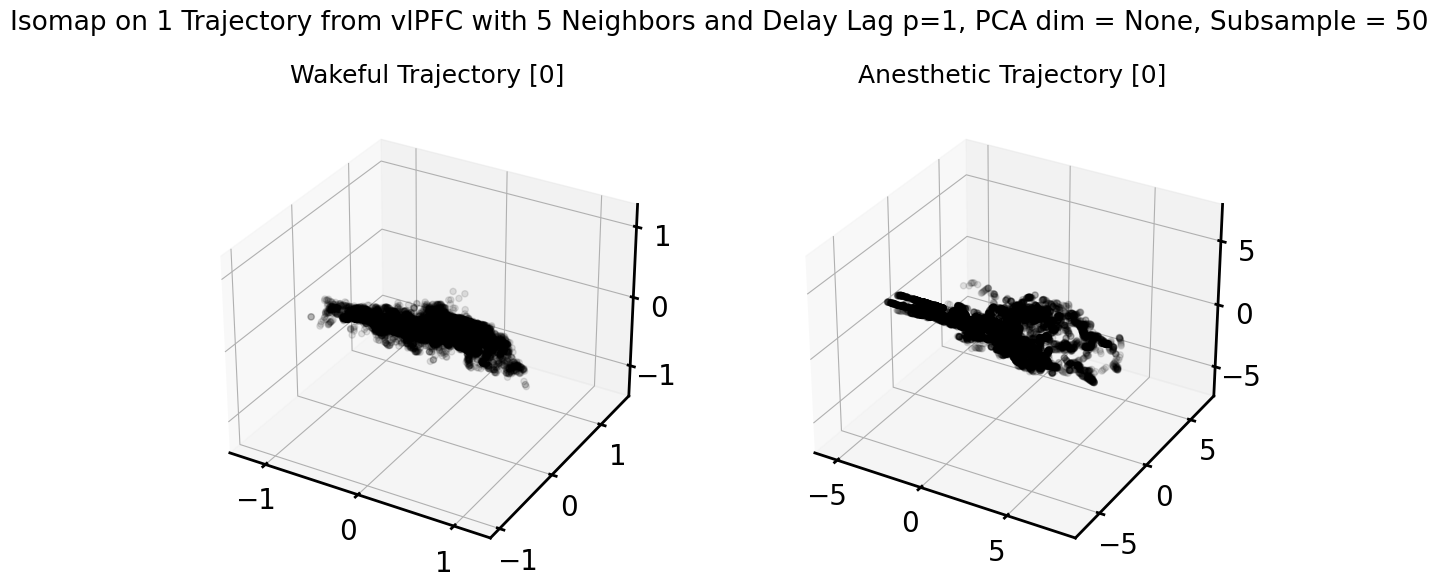

In [54]:
%matplotlib inline
# plot_start = -2000
# plot_length = 4000
# cbar_step = 1000

plot_start = -leadup
plot_length = leadup + post
cbar_step = int((leadup + post)/4)
# plot_start = 0
# plot_length = 500
# cbar_step = 100
# plot_start = -leadup
# plot_length = 20000
# cbar_step = 1000
three_dim = True
trial_nums = [0]
density_plot = True
scatter = True
norm = colors.Normalize(vmin=plot_start, vmax=plot_start + plot_length)
cmap = plt.cm.get_cmap('RdYlBu_r')

if three_dim:
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(projection="3d"))
else:
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

if scatter:
    plot_funcs = [axs[0].scatter, axs[1].scatter]
else:
    plot_funcs = [axs[0].plot, axs[1].plot]
    
for trial_num in trial_nums:
    if density_plot:
        c = 'k'
        alpha = 0.1
        if not three_dim:
            plot_funcs[0](lfp_transformed_wake[trial_num, :, 0], lfp_transformed_wake[trial_num, :, 1], color=c, alpha=alpha)
            plot_funcs[1](lfp_transformed_anesthesia[trial_num, :, 0], lfp_transformed_anesthesia[trial_num, :, 1], color=c, alpha=alpha)
        else:
            plot_funcs[0](lfp_transformed_wake[trial_num, :, 0], lfp_transformed_wake[trial_num, :, 1], lfp_transformed_wake[trial_num, :, 2], color=c, alpha=alpha)
            plot_funcs[1](lfp_transformed_anesthesia[trial_num, :, 0], lfp_transformed_anesthesia[trial_num, :, 1], lfp_transformed_anesthesia[trial_num, :, 2], color=c, alpha=alpha)
    else:
        for i in range(plot_start + leadup, plot_start + leadup + plot_length, 2):
            c = cmap(norm(i - leadup))
            alpha=0.8
            if not three_dim:
                plot_funcs[0](lfp_transformed_wake[trial_num, i:i+2, 0], lfp_transformed_wake[trial_num, i:i+2, 1], color=c, alpha=alpha)
                plot_funcs[1](lfp_transformed_anesthesia[trial_num, i:i+2, 0], lfp_transformed_anesthesia[trial_num, i:i+2, 1], color=c, alpha=alpha)
            else:
                plot_funcs[0](lfp_transformed_wake[trial_num, i:i+2, 0], lfp_transformed_wake[trial_num, i:i+2, 1], lfp_transformed_wake[trial_num, i:i+2, 2], color=c, alpha=alpha)
                plot_funcs[1](lfp_transformed_anesthesia[trial_num, i:i+2, 0], lfp_transformed_anesthesia[trial_num, i:i+2, 1], lfp_transformed_anesthesia[trial_num, i:i+2, 2], color=c, alpha=alpha)
axs[0].set_title(f'Wakeful Trajectory {trial_nums}', fontsize=18)
axs[1].set_title(f'Anesthetic Trajectory {trial_nums}', fontsize=18)
if three_dim:
    set_axes_equal(axs[0])
    set_axes_equal(axs[1])

fig.suptitle(f"Isomap on {num_trajs} Trajector{'ies' if num_trajs > 1 else 'y'} from {area} with {n_neighbors} Neighbors and Delay Lag p={p}, PCA dim = {n_pca_components}, Subsample = {subsample}", fontsize=19)
# fig.suptitle(f"Isomap on Continuous Trajector{'ies' if num_trajs > 1 else 'y'} from {area} with {n_neighbors} Neighbors and Delay Lag p={p}, PCA dim = {n_pca_components}, Subsample = {subsample}", fontsize=19)
plt.tight_layout()

if not density_plot:
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.25, 0.01, 0.5])
    # cbar = fig.colorbar(sm, cax=cbar_ax, ticks=np.arange(0, leadup + post, 250), label='Time Relative to Tone (ms)')
    # cbar.ax.set_yticklabels(np.arange(-leadup, post, 250), fontsize=12)

    cbar = fig.colorbar(sm, cax=cbar_ax, ticks=np.arange(plot_start, plot_start + plot_length + 1, cbar_step), label='Time Relative to Tone (ms)')
    cbar.ax.set_yticklabels(np.arange(plot_start, plot_start + plot_length + 1, cbar_step), fontsize=12)
    cbar.set_label(label=f'Time Relative to {time_loc_type.capitalize()} Event (ms)', fontsize=14)

plt.show()

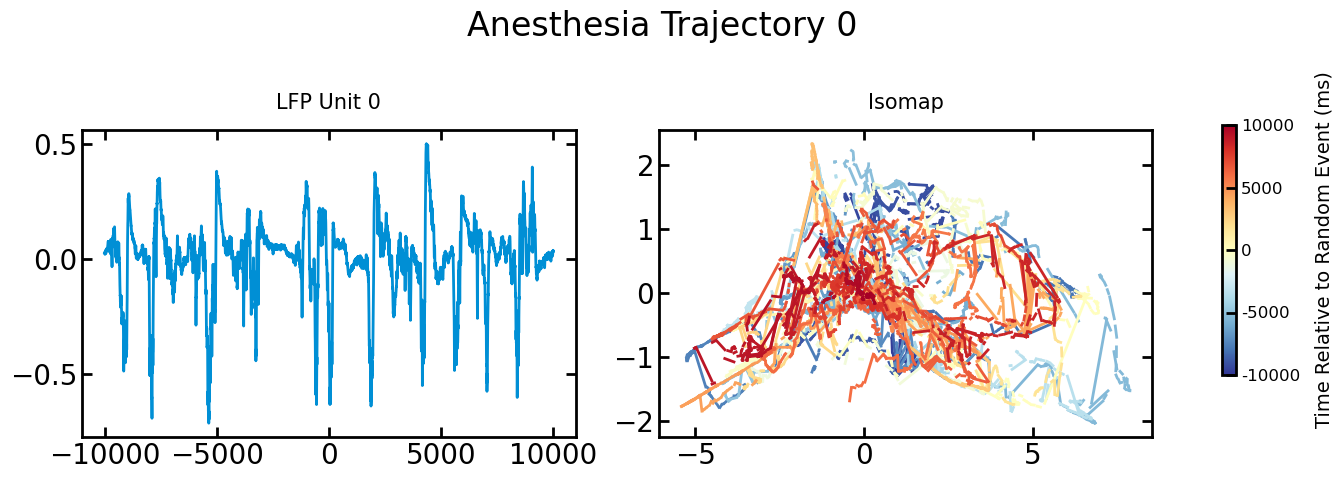

In [55]:
fig = plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
traj_num = 0
plt.plot(np.arange(-leadup, post), lfp_traj_anesthesia_pca[traj_inds_anesthesia[traj_num]][:, 0])
plt.title('LFP Unit 0', fontsize=15)
    
plt.subplot(1, 2, 2)
for i in range(0, lfp_transformed_anesthesia.shape[1], 2):
    plt.plot(lfp_transformed_anesthesia[traj_num][i:i+2, 0], lfp_transformed_anesthesia[traj_num][i:i+2, 1], c=cmap(norm(i - leadup)))
plt.title('Isomap', fontsize=15)

fig.suptitle(f'Anesthesia Trajectory {traj_num}')

plt.tight_layout()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.25, 0.01, 0.5])
# cbar = fig.colorbar(sm, cax=cbar_ax, ticks=np.arange(0, leadup + post, 250), label='Time Relative to Tone (ms)')
# cbar.ax.set_yticklabels(np.arange(-leadup, post, 250), fontsize=12)

cbar = fig.colorbar(sm, cax=cbar_ax, ticks=np.arange(-leadup, post + 1, cbar_step), label='Time Relative to Tone (ms)')
cbar.ax.set_yticklabels(np.arange(-leadup, post + 1, cbar_step), fontsize=12)
cbar.set_label(label=f'Time Relative to {time_loc_type.capitalize()} Event (ms)', fontsize=14)
    

    
plt.show()

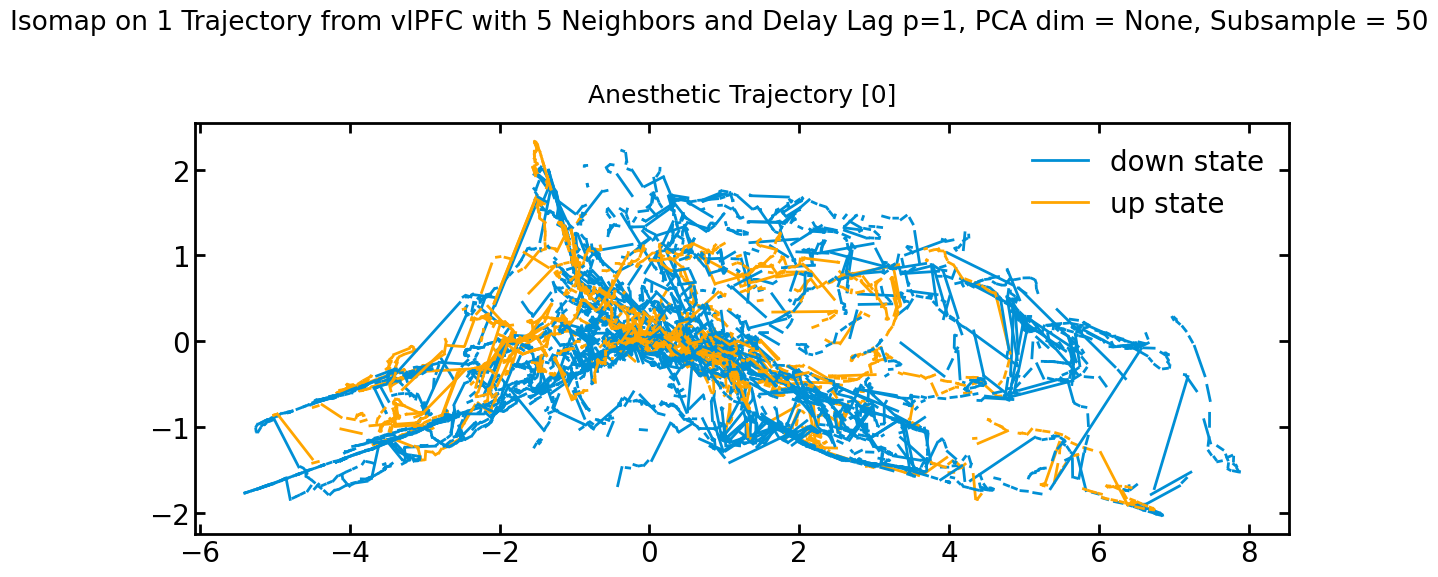

In [57]:
%matplotlib inline
# plot_start = -2000
# plot_length = 4000
# cbar_step = 1000

plot_start = -leadup
plot_length = leadup + post
cbar_step = int((leadup + post)/4)

# plot_start = 0
# plot_length = 1000
# cbar_step = 100
# plot_start = -leadup
# plot_length = 20000
# cbar_step = 1000
three_dim = False
trial_nums = [0]
norm = colors.Normalize(vmin=plot_start, vmax=plot_start + plot_length)
cmap = plt.cm.get_cmap('RdYlBu_r')

if three_dim:
    fig, axs = plt.subplots(1, 1, figsize=(12, 6), subplot_kw=dict(projection="3d"))
else:
    fig, axs = plt.subplots(1, 1, figsize=(12, 6))

# ax = axs[0]
# for trial_num in trial_nums:
#     t = int(times_anesthesia[area][time_loc_type][traj_inds_anesthesia[trial_num]])
#     ud_states = up_down_dict['vlPFC'][t:t + (leadup + post)]
#     for i in range(plot_start + leadup, plot_start + leadup + plot_length, 2):
#         if (ud_states[i] + ud_states[i + 1]) > 0:
#             c = 'orange'
#         else:
#             c = 'C0'
#         if not three_dim:
#             ax.plot(lfp_transformed_wake[trial_num, i:i+2, 0], lfp_transformed_wake[trial_num, i:i+2, 1], c=c)
#         else:
#             ax.plot(lfp_transformed_wake[trial_num, i:i+2, 0], lfp_transformed_wake[trial_num, i:i+2, 1], lfp_transformed_wake[trial_num, i:i+2, 2], c=c)
# ax.set_title(f'Wakeful Trajectory {trial_nums}', fontsize=18)
# if three_dim:
#     set_axes_equal(ax)
        
ax = axs
for trial_num in trial_nums:
    t = int(times_anesthesia[area][time_loc_type][traj_inds_anesthesia[trial_num]])
    ud_states = up_down_dict['vlPFC'][t:t + (leadup + post)]
    for i in range(plot_start + leadup, plot_start + leadup + plot_length, 2):
        if (ud_states[i] + ud_states[i + 1]) > 0:
            c = 'orange'
        else:
            c = 'C0'
        if not three_dim:
            ax.plot(lfp_transformed_anesthesia[trial_num, i:i+2, 0], lfp_transformed_anesthesia[trial_num, i:i+2, 1], c=c)
        else:
            ax.plot(lfp_transformed_anesthesia[trial_num, i:i+2, 0], lfp_transformed_anesthesia[trial_num, i:i+2, 1], lfp_transformed_anesthesia[trial_num, i:i+2, 2], c=c)
ax.set_title(f'Anesthetic Trajectory {trial_nums}', fontsize=18)
if three_dim:
    set_axes_equal(ax)

fig.suptitle(f"Isomap on {num_trajs} Trajector{'ies' if num_trajs > 1 else 'y'} from {area} with {n_neighbors} Neighbors and Delay Lag p={p}, PCA dim = {n_pca_components}, Subsample = {subsample}", fontsize=19)
# fig.suptitle(f"Isomap on Continuous Trajector{'ies' if num_trajs > 1 else 'y'} from {area} with {n_neighbors} Neighbors and Delay Lag p={p}, PCA dim = {n_pca_components}, Subsample = {subsample}", fontsize=19)
plt.tight_layout()
    
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# fig.subplots_adjust(right=0.85)
# cbar_ax = fig.add_axes([0.9, 0.25, 0.01, 0.5])
# # cbar = fig.colorbar(sm, cax=cbar_ax, ticks=np.arange(0, leadup + post, 250), label='Time Relative to Tone (ms)')
# # cbar.ax.set_yticklabels(np.arange(-leadup, post, 250), fontsize=12)

# cbar = fig.colorbar(sm, cax=cbar_ax, ticks=np.arange(plot_start, plot_start + plot_length + 1, cbar_step), label='Time Relative to Tone (ms)')
# cbar.ax.set_yticklabels(np.arange(plot_start, plot_start + plot_length + 1, cbar_step), fontsize=12)
# cbar.set_label(label=f'Time Relative to {time_loc_type.capitalize()} Event (ms)', fontsize=14)

ln1 = plt.plot([], c='C0', label='down state')
ln2 = plt.plot([], c='orange', label='up state')
plt.legend()


plt.show()

In [402]:
# pd.to_pickle({
#     'isomap': isomap, 
#     'lfp_transformed_anesthesia': lfp_transformed_anesthesia, 
#     'lfp_transformed_wake': lfp_transformed_wake, 
#     'traj_inds_anesthesia': traj_inds_anesthesia, 
#     'traj_inds_wake': traj_inds_wake,
#     'time_anesthesia': times_anesthesia,
#     'times_wake': times_wake,
#     'time_loc_type': time_loc_type}, 
# os.path.join("/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp_isomap3.pkl"))

# TPHATE

In [97]:
sys.path.append('/om2/user/eisenaj/code/repos/TPHATE')
from tphate import tphate

In [98]:
tphate_embed = tphate.TPHATE(n_components=3, decay=40)

In [107]:
lfp_anesthesia_in.shape

(800, 64)

In [ ]:
lfp_transformed_wake = tphate_embed.fit_transform(lfp_anesthesia_in)

Calculating TPHATE...
  Running TPHATE on 800 observations and 64 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.07 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.09 seconds.
  Learning the autocorrelation function...
  Calculating Autocorr kernel...
    Dropoff point: 5
  Combining PHATE operator and autocorr operator
  Calculating optimal t...
    Automatically selected t = 31
  Calculated optimal t in 0.34 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.23 seconds.
  Calculating metric MDS...


In [ ]:
lfp_transformed_anesthesia = tphate_embed.fit_transform(lfp_traj_anesthesia_pca[:1000])

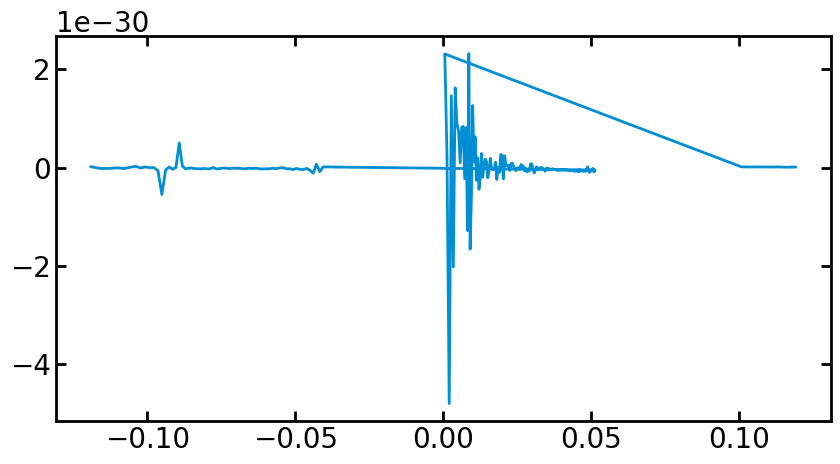

In [181]:
plt.plot(lfp_traj_anesthesia_transformed[:, 0], lfp_traj_anesthesia_transformed[:, 1])

In [ ]:
%matplotlib inline
# plot_start = -2000
# plot_length = 4000
# cbar_step = 1000
plot_start = 0
plot_length = 1000
cbar_step = 100
# plot_start = -leadup
# plot_length = 20000
# cbar_step = 1000
three_dim = True
trial_num = 0
norm = colors.Normalize(vmin=plot_start, vmax=plot_start + plot_length)
cmap = plt.cm.get_cmap('RdYlBu_r')

if three_dim:
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(projection="3d"))
else:
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

ax = axs[0]
for i in range(plot_start + leadup, plot_start + leadup + plot_length, 2):
    if three_dim:
        ax.plot(lfp_transformed_wake[trial_num, i:i+2, 0], lfp_transformed_wake[trial_num, i:i+2, 1], c=cmap(norm(i - leadup)))
    else:
        ax.plot(lfp_transformed_wake[trial_num, i:i+2, 0], lfp_transformed_wake[trial_num, i:i+2, 1], lfp_transformed_wake[trial_num, i:i+2, 2], c=cmap(norm(i - leadup)))
ax.set_title(f'Wakeful Trajectory {trial_num}', fontsize=18)
if three_dim:
    set_axes_equal(ax)
        
ax = axs[1]
for i in range(plot_start + leadup, plot_start + leadup + plot_length, 2):
    if three_dim:
        ax.plot(lfp_transformed_anesthesia[trial_num, i:i+2, 0], lfp_transformed_anesthesia[trial_num, i:i+2, 1], c=cmap(norm(i - leadup)))
    else:
        ax.plot(lfp_transformed_anesthesia[trial_num, i:i+2, 0], lfp_transformed_anesthesia[trial_num, i:i+2, 1], lfp_transformed_anesthesia[trial_num, i:i+2, 2], c=cmap(norm(i - leadup)))
ax.set_title(f'Anesthetic Trajectory {trial_num}', fontsize=18)
if three_dim:
    set_axes_equal(ax)

# fig.suptitle(f"Isomap on {num_trajs} Trajector{'ies' if num_trajs > 1 else 'y'} from {area} with {n_neighbors} Neighbors and Delay Lag p={p}")
fig.suptitle(f"Isomap on Continuous Trajector{'ies' if num_trajs > 1 else 'y'} from {area} with {n_neighbors} Neighbors and Delay Lag p={p}")
plt.tight_layout()
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.25, 0.01, 0.5])
# cbar = fig.colorbar(sm, cax=cbar_ax, ticks=np.arange(0, leadup + post, 250), label='Time Relative to Tone (ms)')
# cbar.ax.set_yticklabels(np.arange(-leadup, post, 250), fontsize=12)

cbar = fig.colorbar(sm, cax=cbar_ax, ticks=np.arange(plot_start, plot_start + plot_length + 1, cbar_step), label='Time Relative to Tone (ms)')
cbar.ax.set_yticklabels(np.arange(plot_start, plot_start + plot_length + 1, cbar_step), fontsize=12)
cbar.set_label(label=f'Time Relative to {time_loc_type.capitalize()} Event (ms)', fontsize=14)
    


plt.show()

# Up Down Stuff